# Caso Práctico de Módulo 1: Optimización de campañas de marketing online



* Supongamos el caso en el que tenemos que hacer una campaña de marketing online para promocionar un determinado producto. Para ello se mostrará en una página web un banner con una imagen del producto a promocionar. El equipo de diseño ha realizado 5 imágenes distintas del producto para poner en el banner con el objetivo de captar la atención del usuario para que pulse en el banner y acceda a la web con los detalles del producto a promocionar:

<img src="imgs/img_mo.png" style="width: 700px;"/>

* Dado que no sabemos a priori cual es la imagen del producto que captará mayor atención, debemos de aprender en base a los clicks que se realizan sobre el banner que imagen será las más llamativa y conseguirá más visitas. Para ello aplicaremos el método del Bandido Multi-Brazo con el fin maximizar las visitas a la web del producto a promocionar.

$$Q(imagen_i) = \frac{Nº Clicks}{Nº impresiones de la pagina}$$

* El ***objetivo es encontrar la imagen que capte mayor atención a los usuarios***; es decir que mayor número de clicks obtenga:

$$Q(imagen^{*}) = max Q(imagen_i)$$


* Dado el método a continuación implementado "multi_armed_bandit(num_games=1000, epsilon=0.1, verbose=False)" se pide llamar a este método pasandole un ratio de exploración adecuado (epsilon) para que encuentre la imagen que mayor número de clicks tiene.


In [1]:
import random
import numpy as np

   
    
def multi_armed_bandit(num_games=1000, epsilon=0.1, verbose=False):
    
    bandits = [0.7, 0.01, 0.04, 0.1, 0.05]
    total_reward = 0
    acum_reward_bandit = np.zeros(len(bandits))  # numerador
    num_selected_bandit = np.zeros(len(bandits)) # denominador
    q_bandits = np.zeros(len(bandits))            # Q(a)
    
    if verbose:
        print("Initial Bandits Distribution\n  {}".format(bandits))
    
    for game in range(0,num_games):
        
        old_q_bandits = q_bandits.copy()
        
        if np.random.random() < epsilon:
            bandit = np.random.randint(len(bandits)) # Exploro
        else:
            bandit = np.random.choice(np.flatnonzero(q_bandits == q_bandits.max())) # Exploto 
            
        # Obtengo el reward
        reward = 1 if (np.random.random() < bandits[bandit]) else 0
        
        # Actualizo reward total
        total_reward += reward
        
        # Actualizo valor (Q) de la imagen
        acum_reward_bandit[bandit] += reward
        num_selected_bandit[bandit] += 1
        q_bandits[bandit] = acum_reward_bandit[bandit] / num_selected_bandit[bandit]
        
        if verbose:
            print("\nGAME {game}\n  Old Q_Bandits = {old_q_bandits}\n  Selected Bandit = {bandit} \
                  \n  Reward = {reward}\n  Q_Bandits = {q_bandits}"
                  .format(game=game+1, old_q_bandits=old_q_bandits, bandit=bandit, 
                          reward=reward, q_bandits=q_bandits))
    
    return bandits, total_reward, q_bandits, num_selected_bandit


## Pregunta 1
¿Cuál es el valor de EPSILON que maximiza la image con mayor número de clicks?

### El significado de EPSILON
De acuerdo a Agustín (2022) "Los bandidos, por ser MDPs de un solo estado, son las instancias más básicas del problema de la toma de decisiones secuencial con información limitada. Tratan de manera natural el dilema de la exploración-explotación, permitiendo afrontar cualquier problema que pueda expresarse en los términos del ejemplo de las máquinas tragaperras." Aquí Agustín usa MPD para referise a Procesos de Decisiones de Markov, o aquellos que son fenomenos aleatorios dependientes del tiempo y para los cuales se cumple la propiedad de Markov, que es la propiedad condicional sobre el estado pasado, presente y futuro del sistema de independencia. El trabajo de Agustín gira entorno al dilema de la exploración versus explotación, pero se enfoca mucho más en los métodos y algoritmos de solución que en la determinación del $\epsilon$ óptimo. 

También gracias a Agustin (2022) determinamos que "la naturaleza de nuestro bandido multibrazo es un bandido estocástico es aquel en el que las recompensas generadas tras seleccionar un brazo se extraen de forma independiente de una distribución fija asociada al brazo." Sutton y Bardo (2018) describen los bandidos multibrazos estacionarios como aquellos que se expresan como aquellos cuyos resultados son distribuciones estacionarias que no cambian con el tiempo. Esto también nos lleva a catalogar estos bandidos multibrazos como Bandidos Multibrazos Bernoulli, cuyos resultados son el efecto de una distribución Bernoulli (Agustín acota que "... una distribución Bernoulli (p) devuelve 1 con probabilidad p y 0 en caso contrario"). 

Volviendo al problema del número que maximiza **epsilon**, entendemos que es aquel que minimiza el remordimiento. Definimos remordimiento (del inglés _regret_) como $R_n$ o "la diferencia entre la mayor recompensa esperada y la recompensa esperada por la política que sigue el agente. En este contexto, minimizar el remordimiento equivale a maximizar la recompensa total acumulada" (Agustín, 2022). El problema de minimizar el remordimiento y maximizar la recompensa ajustando **epsilon** es uno estocastico en naturaleza cuando el problema es estacionario y ha sido atacado por Sutton y Bardo, por Foo, y por Burke. 

### Enfoques de Maximización de la Recompensa 
Estudiando el problema, vemos enfoques con código experimental muy completo de varios autores. En este trabajo nombraremos los de Kenneth Foo, Matthew Burke, Richard Sutton y Andrew Burton. 

Foo ataca el problema de maximizar la recompensa escribiendo su propio algoritmo para determinar el mejor valor de **epsilon** en Python, creando el método ```EpsilonGreedy()```. Foo aplica el algoritmo a una serie intensa de interacciones cuyo proposito es el de superar la naturaleza estocastica de la simulación y la necesidad de minimizar errores aleatorios. Después de simular 5,000 episodios con valores de **epsilon** en rangos de 0.1 al 0.5 dos observaciones saltan a la vista. 

1. La naturaleza asintótica de las funciones de epsilon
2. La velocidad con la que el algoritmo alcanza a maximizar la recompensa esta correlacionado con el valor de **epsilon** y la mayor libertad de explorar. 

Así en la serie de 5,000 simulaciones el mejor valor promedio de selección del bandido lo tiene $\epsilon=0.1$ pero el mejor valor promedio acumulado de recompensas los obtiene $\epsilon=0.2$ que converge más rápido hacia el menor valor de remordimiento porque tiene más libertad de exploración. 

Foo descubre - pero no profundiza - en sus análisis sobre la diferencia de los valores de **epsilon** cuando la distribución de valores posibles de los n bandidos multibrazos es pequeña. Una distribución de valores más acotadas complica el algoritmo el cual tarda más en converger.

Burke (2019) parte su análisis determinando la diferencia entre bandidos del tipo _Bernoulli_ y del tipo _Gausiano_. Burke está a la vez más interesado en valores muy acotados de **epsilon**, donde $0.05 > \epsilon > 0.1$. Aquí Burke sin embargo agrega un factor novedoso: la variable _degradacion de EPSILON_ que aumenta la probabilidad de explotación aunque el agente en el algoritmo haya tomado la decisión de explorar. Dicha variable aumenta en peso y valor a medida que el algoritmo explora, y su objetivo es degradar el indice de exploración con el objetivo de minimizar el remordimiento. 

El mismo Burke llega a la conclusión que la teoría es novedosa, pero que en escenarios de alto volumen de ruido en el sistema la variable que degrada **epsilon** puede converger más lentamente hacia la solución optima, e inclusive en series muy ruidosas converger hacia valores más altos de epsilon (por ejemplo, un valor de epsilon = 0.05 con degradación converge a un valor de epsilon = 0.1). 

Finalmente Sutton y Bardo abordan el problema del valor óptimo de _greedy epsilon_ situandolo en 0.1 con la ayuda del uso de _Upper Bound Confidence Action Selection_. La aplicación de la cota superior de confianza también la cubre Agustín, pero la explicación y aplicación de la misma no será cubierta en el siguiente trabajo. 

### Maximizando la Recompensa en el Problema
Retornando a nuestro problema, hagamos un experimento iterando por valores de **epsilon** y determinando el mejor número de clics según la variación de valores. Evaluaremos valores de **epsilon** de 0,05 a 0,5. 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=4)
import operator

epsilon_values = [0.05,0.1,0.2,0.3,0.4,0.5]
clicks_test = []

for this_epsilon in epsilon_values:
    bandits, total_reward, q_bandits, num_selected_bandit = multi_armed_bandit(num_games=1000, 
                                                                           epsilon=this_epsilon, 
                                                                           verbose=False)
    clicks_test.append(total_reward)

print("Final de Evaluación Valores Múltiples de Epsilon")   

# Código de obtener máximo valor e índice de ARRAY de https://stackoverflow.com/questions/6193498/pythonic-way-to-find-maximum-value-and-its-index-in-a-list
index, value = max(enumerate(clicks_test), key=operator.itemgetter(1))
print("Número más alto de clicks: ", value)
print("Valor óptimo de EPSILON: ", epsilon_values[index])


Final de Evaluación Valores Múltiples de Epsilon
Número más alto de clicks:  627
Valor óptimo de EPSILON:  0.1


En nuestro experimento, el valor de epsilon que maximiza el número de clicks de la mejor imagen es 0.05. Dado la naturaleza de BMB Bernoulli del caso, con una probabilidad de 700 clicks en la imagen 1 ($p = 0.7$) el remordimiento en nuestro experimento es solo 2. Podemos comprobarlo volviendo a correr el método:

Initial Bandits Distribution
  [0.7, 0.01, 0.04, 0.1, 0.05]
Bandits Distribution games
  [849.   8.  10. 122.  11.]
Q(a) Bandits
  [0.7373 0.     0.1    0.123  0.    ]
CLICKS: 642


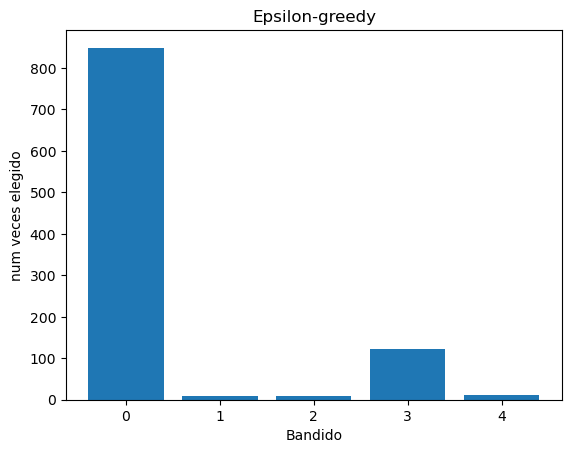

In [15]:
EPSILON = 0.05
bandits, total_reward, q_bandits, num_selected_bandit = multi_armed_bandit(num_games=1000, 
                                                                           epsilon=EPSILON, 
                                                                           verbose=False)

print("Initial Bandits Distribution\n  {}".format(bandits))
print("Bandits Distribution games\n  {}".format(num_selected_bandit))
print("Q(a) Bandits\n  {}".format(q_bandits))
print("CLICKS: {}".format(total_reward))

# Mostramos en una gráfica de barras el número de veces que elegimos cada "tragaperras"
plt.title('Epsilon-greedy')
plt.bar(range(0,len(bandits)), num_selected_bandit)
plt.xlabel('Bandido')
plt.ylabel('num veces elegido')
plt.show()

### Pregunta 2
¿Cuál es la imagen que más clicks obtiene y cuantos? Retornando a nuestro experimento inicial, la imagen A (con identificador en el array de Python 0) tiene el mejor número de clicks con 678.

### Pregunta 3
Poniendo un ratio de explotación del 100%, ¿que resultado obtenemos?

Fijar **epsilon** a 0 equivale a siempre explotar y nunca explorar. La naturaleza de nuestra función es aleatoria, y siempre hay espacio para sorpresas, pero lo más probable es que escoja solo una imagen y explote la misma 100% del tiempo, ya que al algoritmo no le interesa explorar para nada. 

Initial Bandits Distribution
  [0.7, 0.01, 0.04, 0.1, 0.05]
Bandits Distribution games
  [979.   6.   3.   8.   4.]
Q(a) Bandits
  [0.7058 0.     0.     0.     0.    ]
CLICKS: 691


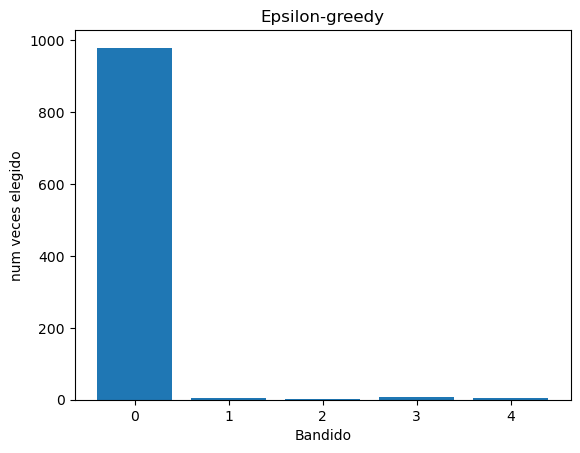

In [21]:
EPSILON = 0.0
bandits, total_reward, q_bandits, num_selected_bandit = multi_armed_bandit(num_games=1000, 
                                                                           epsilon=EPSILON, 
                                                                           verbose=False)

print("Initial Bandits Distribution\n  {}".format(bandits))
print("Bandits Distribution games\n  {}".format(num_selected_bandit))
print("Q(a) Bandits\n  {}".format(q_bandits))
print("CLICKS: {}".format(total_reward))

# Mostramos en una gráfica de barras el número de veces que elegimos cada "tragaperras"
plt.title('Epsilon-greedy')
plt.bar(range(0,len(bandits)), num_selected_bandit)
plt.xlabel('Bandido')
plt.ylabel('num veces elegido')
plt.show()

## Bibliografía
Agustín Herero, M. (2022) Bandidos estocásticos: introducción, algoritmos y experimentos. Trabajo de Fin de Grado del Doble Grado en Ingeniería Informática - Matemáticas. Universidad Complutense de Madrid, Recuperado de  https://eprints.ucm.es/id/eprint/74162/1/HERRERO%20AGUST%C3%8DN%2054533_MARCOS_HERRERO_AGUSTIN_Bandidos_estocasticos_introduccion__algoritmos_y_experimentos_1398832_1641158557.pdf

Sutton, R. y Bardo, A. (2018) Reinforcement Learning - An Introduction. The MIT Press. Cambridge, USA. 

Foo, K. (2020) Multi-Armed Bandit Analysis of Epsilon Greedy Algorithm. Analytics Vidhya. Recuperado de https://medium.com/analytics-vidhya/multi-armed-bandit-analysis-of-epsilon-greedy-algorithm-8057d7087423

Burke, M. (2019) Multi-Armed Bandits Exploration. Github. Recuperado de https://mwburke.github.io/data%20science/2019/06/18/bandits-exploration.html
